In [365]:
# import some packages

import nltk
from nltk.corpus import words
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from english_words import english_words_lower_alpha_set
import seaborn as sns
sns.set_style("darkgrid")

# Import word lists

## We have two choices:

In [331]:
word_list = english_words_lower_alpha_set
print(len(word_list)) # this contains only 25k words

word_list = words.words()
print(len(word_list)) # this word list contains many more words

25463
236736


## Filter only for 5 letter words

In [332]:
# get 5 letter words from word_list
five_letter_words = [w for w in word_list if len(w) == 5]
# convert all words to lower case
five_letter_words = [w.lower() for w in five_letter_words]
len(five_letter_words)

10422

We have 10k 5-letter words

## Calculate letter frequency

(maybe it would be better to calculate letter/word freq)

In [333]:
#concat a list of words to a string
def concat_list_to_string(list_of_words):
    return ''.join(list_of_words)
    
one_string = concat_list_to_string(five_letter_words)

def char_frequency(str1):
    dict = {}
    for n in str1:
        keys = dict.keys()
        if n in keys:
            dict[n] += 1
        else:
            dict[n] = 1
    return dict
char_freq = char_frequency(one_string)

char_freq_sorted = dict(sorted(char_freq.items(), key=lambda item: item[1], reverse=True))

This is the letter frequency for each letter:

In [334]:
char_freq_sorted

{'a': 5879,
 'e': 5019,
 'r': 3640,
 'o': 3372,
 'i': 3365,
 's': 2954,
 'l': 2848,
 'n': 2827,
 't': 2807,
 'u': 2333,
 'c': 1878,
 'y': 1870,
 'd': 1703,
 'm': 1655,
 'h': 1639,
 'p': 1508,
 'b': 1397,
 'g': 1319,
 'k': 1121,
 'w': 764,
 'f': 755,
 'v': 555,
 'z': 308,
 'j': 251,
 'x': 241,
 'q': 102}

## Calculate a "score for each letter what we can use later to be able to chose next words more efficiently

In [335]:
# for each word in a list calculate letter score
def letter_score(word):
    score = 0
    letter_list = []
    for letter in word:
        if letter not in letter_list:
            score += char_freq_sorted[letter]
        letter_list.append(letter)
    return score

In [336]:
letter_score_list = [letter_score(w) for w in five_letter_words]
# create a dataframe with word and score
df_word_score = pd.DataFrame({'word': five_letter_words, 'score': letter_score_list})
# sort by score
df_word_score = df_word_score.sort_values(by=['score'], ascending=False).reset_index(drop=True)
df_word_score['unique_letters'] = df_word_score['word'].apply(lambda x: len(set(x)))
#drop duplicates
df_word_score = df_word_score.drop_duplicates(subset=['word'], keep='first').reset_index(drop=True)

## Top words based on letter score

In [360]:
df_word_score[df_word_score['word'] == 'aisle']

,word,score,unique_letters
48,aisle,20065,5


In [337]:
df_word_score[0:20]

,word,score,unique_letters
0,arose,20864,5
1,oreas,20864,5
2,raise,20857,5
3,serai,20857,5
4,aries,20857,5
5,arise,20857,5
6,leora,20758,5
7,ariel,20751,5
8,erian,20730,5
9,reina,20730,5


# Write the actual Wordl game

In [394]:
def play_game(solution = 'random', five_letter_words_list = five_letter_words, player_play = False, starting_guess = 'random', silence = False, word_table = df_word_score):

    top_words_table = word_table.copy()
    five_letter_words_list = five_letter_words_list.copy()

    if not silence:
        print('choosing from this many words: ', len(five_letter_words_list))

    # get a random word from the list. This is the word that we need to figure out
    if solution == 'random':
        solution = random.choice(list(five_letter_words_list))
        
        
    board = ["-"] * 5 * 6
    score_board = ["0"] * 5 * 6
    score_list = []

    green_score = '2'
    yellow_score = '1'
    black_score = '-1'


    # print the empty board and score_board
    if not silence:
        print(board)
        print(score_board)
    
    def play_one_chance():

        # get the player to enter a letter
        if player_play:

            word_input = input("Enter a word: ")

        else:

            how_many_dash = board.count('-')

            # do this at the 1st round
            if starting_guess == 'random' and how_many_dash == 30:
                #random chose from five_letter_words_list
                word_input = random.choice(list(five_letter_words_list))

            elif starting_guess != 'random' and how_many_dash == 30:
                word_input = starting_guess
            
            # when we are not the 1st round
            elif how_many_dash < 30:

                # this part can be more much more efficiently written
                # right now in every round i check each letter from beginning to the end of previous rounds too
                # there is no need to to check the letters that were already played because we check them when they are played

                for i in range(len(score_board) - how_many_dash):

                    if score_board[i] == green_score:
                        for word in five_letter_words_list:
                            if word[i % 5] != board[i]:
                                five_letter_words_list.remove(word)

                    if score_board[i] == yellow_score:
                        for word in five_letter_words_list:
                            if board[i] not in word:
                                five_letter_words_list.remove(word)
                    
                    if score_board[i] == black_score:
                        for word in five_letter_words_list:
                            if board[i] in word:
                                five_letter_words_list.remove(word)

                # choose the next word                
                top_words_table_new = top_words_table[top_words_table['word'].isin(five_letter_words_list)]
                top_words_table_new = top_words_table_new.sort_values(by=['score'], ascending=False).reset_index(drop=True) # order the list by score

                #word_input = random.choice(list(five_letter_words_list))
                word_input = top_words_table_new['word'][0]

        if not silence:
            print('choosing from this many words: ', len(five_letter_words_list))


        if word_input in five_letter_words_list:
            
            if not silence:
                print("Five letter word found as input!")
                
            return(word_input)
        else:
            
            if not silence:
                print("No five letter word found as input! Give something else!")
            
            return(play_one_chance())

    def update_board(board,i,word_input):
        board[(i * 5):(5 + i * 5)] = word_input
        return(board)

    def update_score_board(score_board,i,word_input):
        score_board[(i * 5):(5 + i * 5)] = [green_score if (word_input[w] in solution and  word_input[w]==solution[w]) else 
                                            yellow_score if (word_input[w] in solution and word_input[w]!=solution[w]) else
                                            black_score for w in range(5)]
        return(score_board)

    for i in range(6):

        if not silence:
            print('### Round: ', i + 1, ' ###')

        word_input = play_one_chance()
        
        if not silence:
            print('Given word: ', word_input)

        if word_input == solution:
            if not silence:
                print("Solution found!")
            # convert string to list
            word_input = list(word_input)

            board = update_board(board,i,word_input)
            score_board = update_score_board(score_board,i,word_input)

            #calculate score
            score_new = list(map(int, score_board))
            score_new_total = 0
            for numbers in score_new:
                score_new_total = score_new_total + numbers
            score_list.append(score_new_total)

            if not silence:
                print(board)
                print(score_board)
            player_won = True
            break
        else:
            if not silence:
                print("Solution not found!")
            # convert string to list
            word_input = list(word_input)

            board = update_board(board,i,word_input)
            score_board = update_score_board(score_board,i,word_input)

            #calculate score
            score_new = list(map(int, score_board))
            score_new_total = 0
            for numbers in score_new:
                score_new_total = score_new_total + numbers
            score_list.append(score_new_total)
            if not silence:
                print(board)
                print(score_board)
            player_won = False


    if player_won == False:
        if not silence:
            print("Game over you lost!")
        score_list.append(-100)
        score_list.append(-100)
        won = 0
    if player_won == True:
        if not silence:
            print("You won!")
        score_list.append(100)
        won = 1
    
    total_score = sum(score_list)
    
    if not silence:
        print("The solution was: " + solution)
        print("It took: " + str(len(score_list) - 1) + " rounds")
        print("Total score: ", total_score)
        print("Score list: ", score_list)

    return(won, (len(score_list) - 1))



# Play the game

using this the "AI" plays the game. But if you set the 'player_play' argument to True you can try it out yourself.

In [395]:
play_game(player_play=False, solution = 'random', five_letter_words_list = five_letter_words, starting_guess='sound', silence=False)

choosing from this many words:  10422
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
### Round:  1  ###
choosing from this many words:  10422
Five letter word found as input!
Given word:  sound
Solution not found!
['s', 'o', 'u', 'n', 'd', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['2', '-1', '-1', '-1', '-1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
### Round:  2  ###
choosing from this many words:  3085
Five letter word found as input!
Given word:  oreas
Solution not found!
['s', 'o', 'u', 'n', 'd', 'o', 'r', 'e', 'a', 's', '-', '-', '-', '-', '-', '-', '-', '-', '-', '

(1, 6)

# Simulate games
In this case 1000 times

In [400]:
won_list = []
score_list = []

times = 1000
starting_word = 'sound'

for i in tqdm(range(times)):
    w, s = play_game(solution = 'random', five_letter_words_list = five_letter_words, starting_guess=starting_word, silence=True)
    won_list.append(w)
    score_list.append(s)

won_list = np.array(won_list)
score_list = np.array(score_list)

100%|██████████| 1000/1000 [27:30<00:00,  1.65s/it] 


In [403]:
# mean of numpy array
print(np.mean(won_list))
print(np.mean(score_list))

0.551
6.09


Currently the program solves the game in around 55% of the times. On average in 6.12 steps (lost games are indicated with 7).

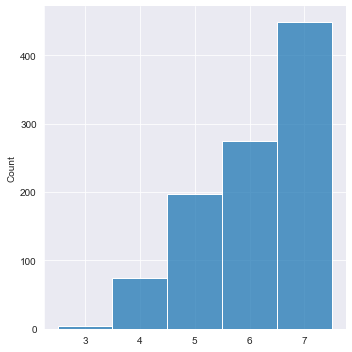

In [404]:
sns.displot(x=score_list, bins=[0, 1, 2, 3, 4, 5, 6, 7], discrete=True)
# 7 means game over